In [2]:
print(__doc__)

import pandas as pd
from pandas.tools.plotting import scatter_matrix
import numpy as np

import time 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn import metrics
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn.metrics import silhouette_samples, silhouette_score

%matplotlib inline 

Automatically created module for IPython interactive environment


In [3]:
#change if necessary to get different clusters
np.random.seed(123)

#downloaded from UCI Machine Repository
original = pd.read_csv('./data/NewsOriginal.csv')

In [4]:
original.head()
us_file = original.drop(labels=[ ' timedelta', 'url', 'shares_2', 'shares_3', 'shares_5', 'shares_log'], axis=1)
#print us_file.head()
mylabels_2 = original['shares_2']
mylabels_3= original['shares_3']
mylabels_5 = original['shares_5']
print us_file.head()

    n_tokens_title   n_tokens_content   n_unique_tokens   n_non_stop_words  \
0               12                219          0.663594                  1   
1                9                255          0.604743                  1   
2                9                211          0.575130                  1   
3                9                531          0.503788                  1   
4               13               1072          0.415646                  1   

    n_non_stop_unique_tokens   num_hrefs   num_self_hrefs   num_imgs  \
0                   0.815385           4                2          1   
1                   0.791946           3                1          1   
2                   0.663866           3                1          1   
3                   0.665635           9                0          1   
4                   0.540890          19               19         20   

    num_videos   average_token_length   ...      min_positive_polarity  \
0            0          

In [4]:
#set variables
data = np.array(us_file)
X = data
batch_size = 45
n_samples, n_features = data.shape
sample_size = 500

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x109ea19d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x109e4b8d0>, ...,
        <matplotlib.axes._subplots.AxesSubplot object at 0x112a33390>, ...,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11457b3d0>, ...,
       ..., 
        <matplotlib.axes._subplots.AxesSubplot object at 0x1714a1510>, ...,
        <matplotlib.axes._subplots.AxesSubplot object at 0x173025d10>, ...,
        <matplotlib.axes._subplots.AxesSubplot object at 0x174bb1550>, ...,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1765baf10>]], dtype=object)

/Users/paulinechow/Envs/ML-OMCS/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


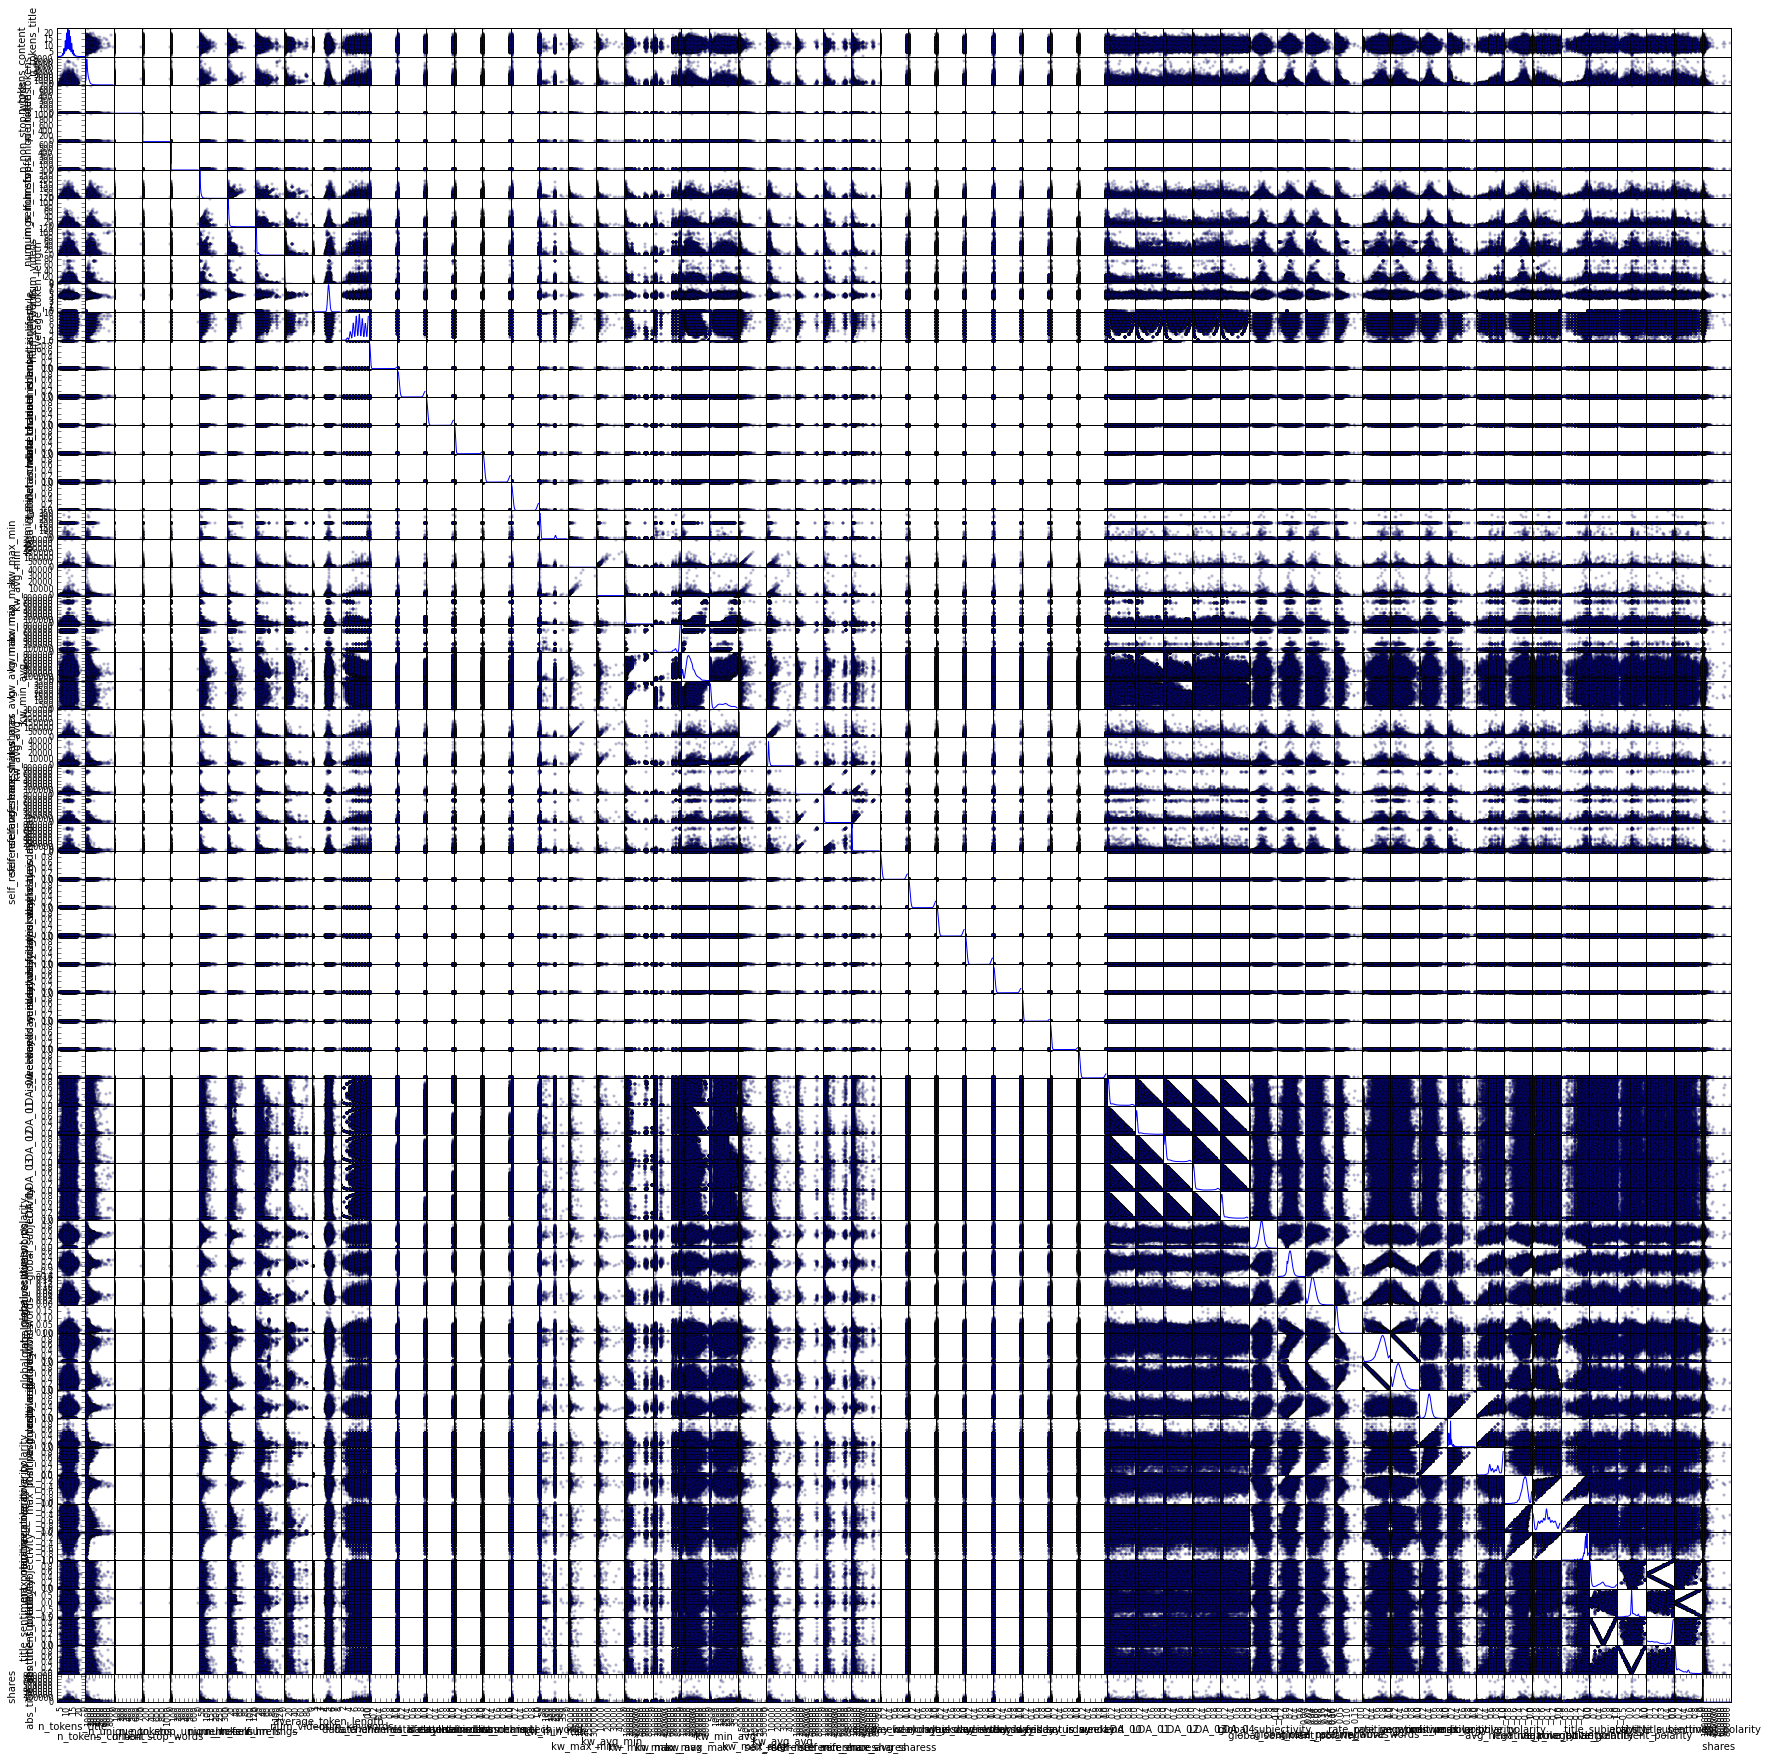

In [13]:
#Takes a long time to run -- not used in first part of the analysis
pd.scatter_matrix(us_file, alpha=0.2, figsize=(30, 30), diagonal='kde')

In [7]:
n_clusters = 8

##############################################################################
# Compute clustering with Means

k_means = KMeans(init='k-means++', n_clusters=n_clusters, n_init=10)
t0 = time.time()
k_means.fit(X)
t_batch = time.time() - t0
k_means_labels = k_means.labels_
k_means_cluster_centers = k_means.cluster_centers_
k_means_labels_unique = np.unique(k_means_labels)

y= k_means_labels
print k_means_labels

#Output clusters to file for next part of analysis
us_file['kmeans1_k8'] = k_means_labels
us_file.to_csv('News_kmeans1_k8.csv', index=False)

from collections import Counter
freqs = Counter(k_means_labels)
print freqs

[1 1 1 ..., 5 5 0]
Counter({2: 11224, 5: 10554, 0: 6064, 3: 5587, 1: 3185, 7: 2692, 4: 224, 6: 114})


In [118]:
import seaborn as sns
#plot values each cluster label

def cluster_dashboard(clust_num, names):
    dash_list = zip(names, k_means.cluster_centers_[clust_num])
    x_val = [x[0] for x in dash_list]
    y_val = [x[1] for x in dash_list]
    dash_chart= sns.barplot(y_val, x_val, orient= 'h')
    plt.xlabel("Cluster "+ str(clust_num) +" of k=8", fontsize=20)
    

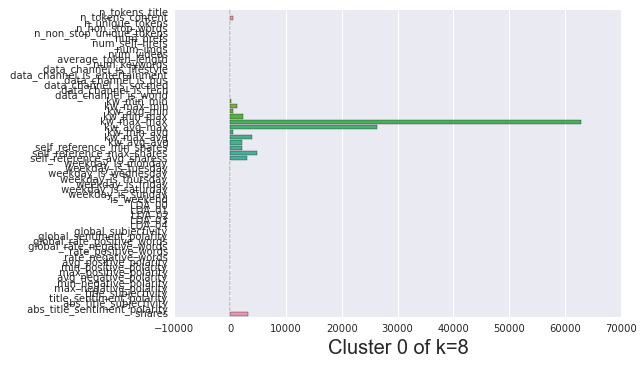

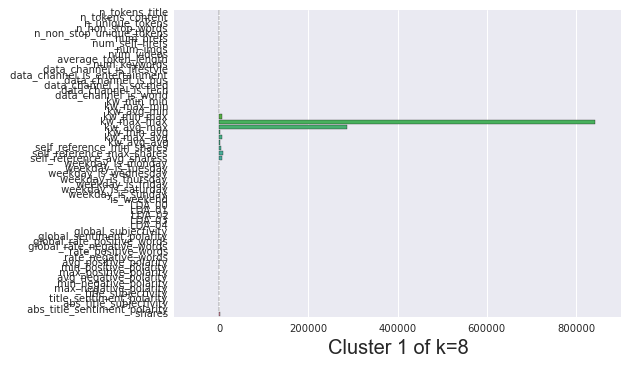

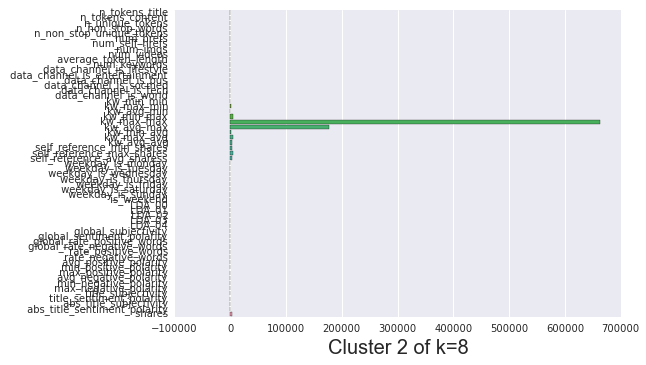

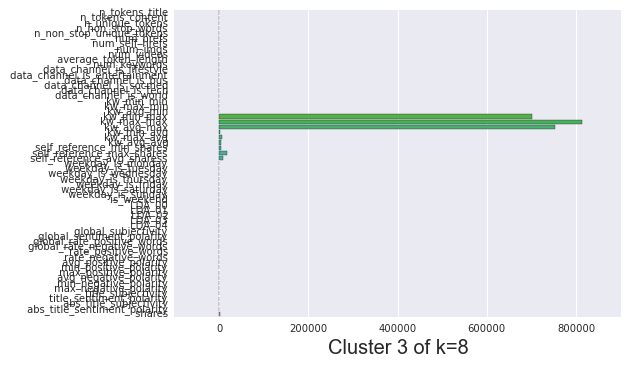

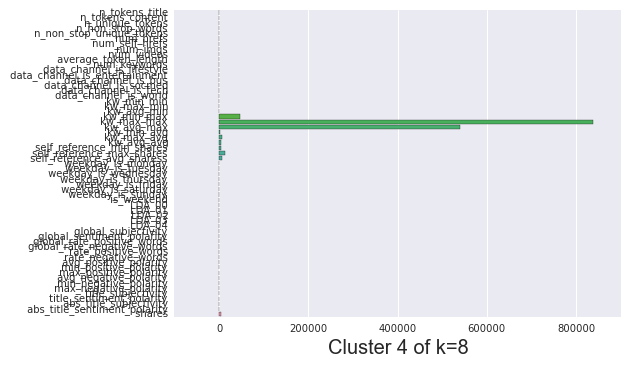

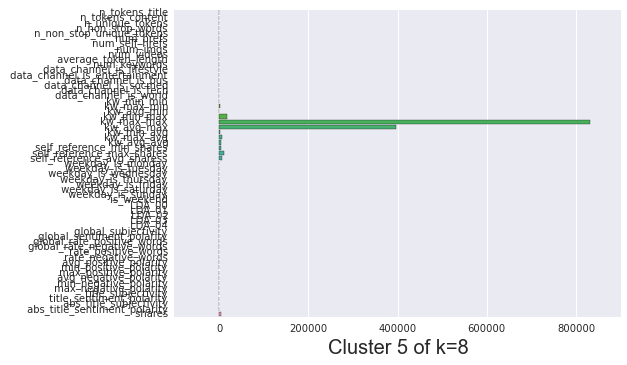

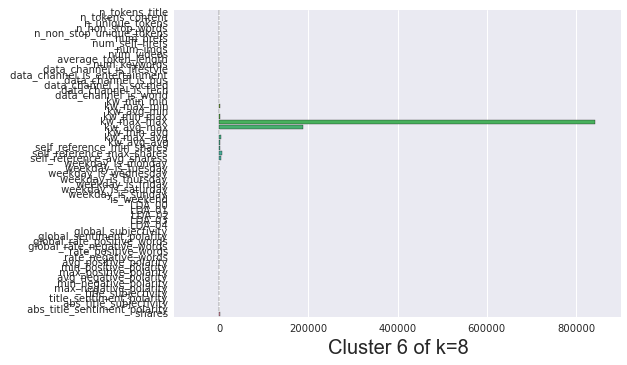

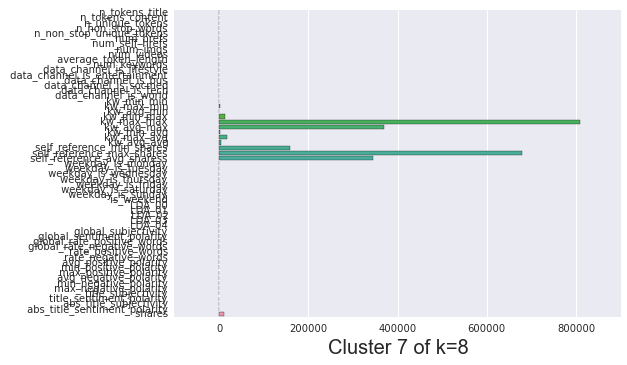

In [119]:
cluster_dashboard(0, us_file.columns.tolist())
plt.show()
cluster_dashboard(1, us_file.columns.tolist())
plt.show()
cluster_dashboard(2, us_file.columns.tolist())
plt.show()
cluster_dashboard(3, us_file.columns.tolist())
plt.show()
cluster_dashboard(4, us_file.columns.tolist())
plt.show()
cluster_dashboard(5, us_file.columns.tolist())
plt.show()
cluster_dashboard(6, us_file.columns.tolist())
plt.show()
cluster_dashboard(7, us_file.columns.tolist())
plt.show()

In [8]:
##############################################################################
# Compute clustering with MiniBatchKMeans

mbk = MiniBatchKMeans(init='k-means++', n_clusters=n_clusters, batch_size=batch_size,
                      n_init=10, max_no_improvement=10, verbose=0)
t0 = time.time()
mbk.fit(X)
t_mini_batch = time.time() - t0
mbk_means_labels = mbk.labels_
mbk_means_cluster_centers = mbk.cluster_centers_
mbk_means_labels_unique = np.unique(mbk_means_labels)


In [9]:
print mbk_means_labels
#print k_means_cluster_centers
print k_means_labels_unique

[1 1 1 ..., 0 0 2]
[0 1 2]


Kmeans -- train time: 1.26s
inertia: 596430713022990.500000


MiniBatchKmeans -- train time: 0.11s
inertia: 597447514919124.500000


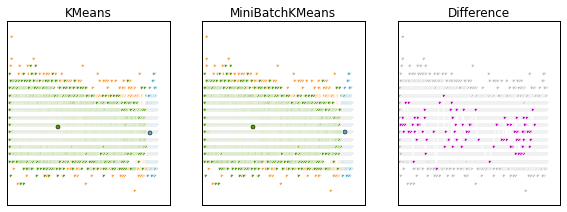

In [10]:
##############################################################################
# Plot results

fig = plt.figure(figsize=(8, 3))
fig.subplots_adjust(left=0.02, right=0.98, bottom=0.05, top=0.9)
colors = ['#4EACC5', '#FF9C34', '#4E9A06']

# We want to have the same colors for the same cluster from the
# MiniBatchKMeans and the KMeans algorithm. Let's pair the cluster centers per
# closest one.

order = pairwise_distances_argmin(k_means_cluster_centers,
                                  mbk_means_cluster_centers)

# KMeans
ax = fig.add_subplot(1, 3, 1)
for k, col in zip(range(n_clusters), colors):
    my_members = k_means_labels == k
    cluster_center = k_means_cluster_centers[k]
    ax.plot(X[my_members, 0], X[my_members, 1], 'w',
            markerfacecolor=col, marker='.')
    ax.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
            markeredgecolor='k', markersize=4)
ax.set_title('KMeans')
ax.set_xticks(())
ax.set_yticks(())
# plt.text(-3.5, 1.8,  'train time: %.2fs\ninertia: %f' % (
#     t_batch, k_means.inertia_))
print 'Kmeans -- train time: %.2fs\ninertia: %f' %(t_batch, k_means.inertia_)
print '\n'

# MiniBatchKMeans
ax = fig.add_subplot(1, 3, 2)
for k, col in zip(range(n_clusters), colors):
    my_members = mbk_means_labels == order[k]
    cluster_center = mbk_means_cluster_centers[order[k]]
    ax.plot(X[my_members, 0], X[my_members, 1], 'w',
            markerfacecolor=col, marker='.')
    ax.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
            markeredgecolor='k', markersize=4)
ax.set_title('MiniBatchKMeans')
ax.set_xticks(())
ax.set_yticks(())
# plt.text(-3.5, 1.8, 'train time: %.2fs\ninertia: %f' %
#          (t_mini_batch, mbk.inertia_))
print 'MiniBatchKmeans -- train time: %.2fs\ninertia: %f' %(t_mini_batch, mbk.inertia_)

# Initialise the different array to all False
different = (mbk_means_labels == 4)
ax = fig.add_subplot(1, 3, 3)

for l in range(n_clusters):
    different += ((k_means_labels == k) != (mbk_means_labels == order[k]))

identic = np.logical_not(different)
ax.plot(X[identic, 0], X[identic, 1], 'w',
        markerfacecolor='#bbbbbb', marker='.')
ax.plot(X[different, 0], X[different, 1], 'w',
        markerfacecolor='m', marker='.')
ax.set_title('Difference')
ax.set_xticks(())
ax.set_yticks(())

plt.show()

('For n_clusters =', 2, 'The average silhouette_score is :', 0.78853133145116872)


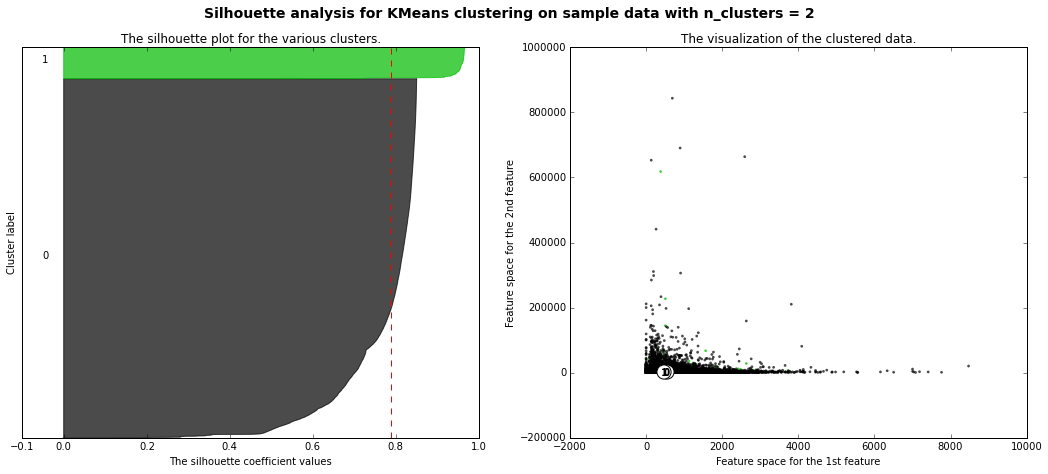

('For n_clusters =', 3, 'The average silhouette_score is :', 0.50018786851260344)


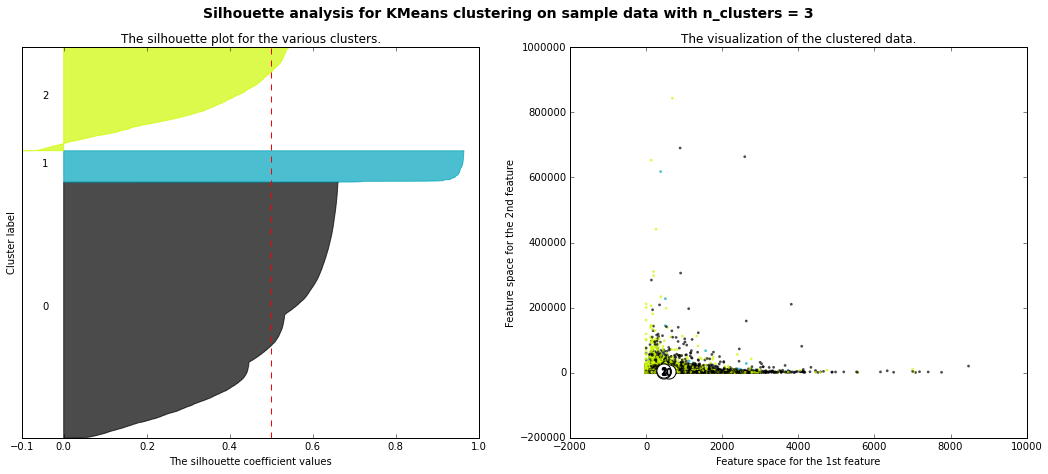

('For n_clusters =', 4, 'The average silhouette_score is :', 0.54341635519940645)


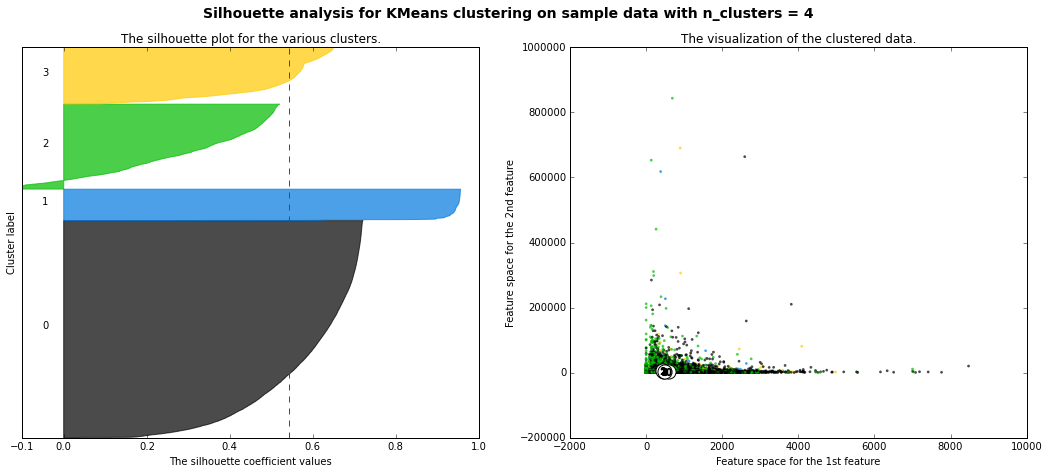

('For n_clusters =', 5, 'The average silhouette_score is :', 0.5516504454176363)


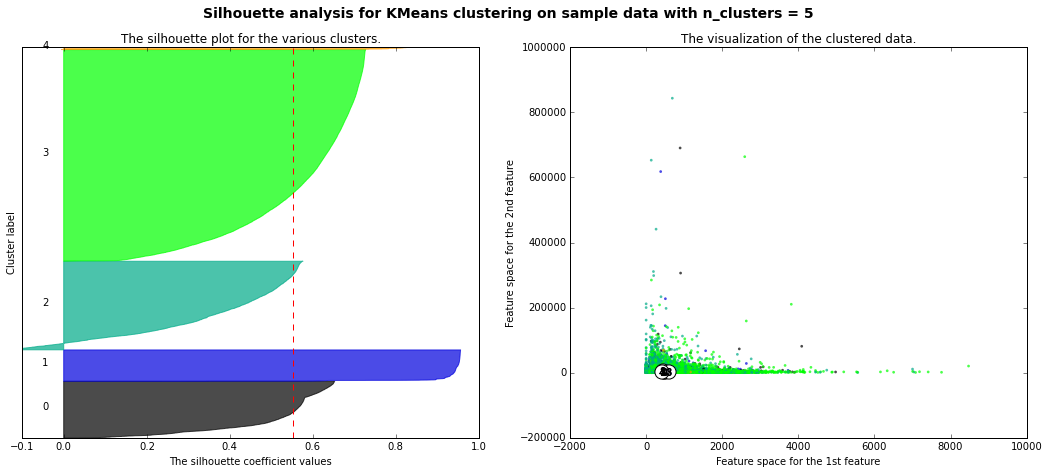

('For n_clusters =', 6, 'The average silhouette_score is :', 0.50621543430550497)


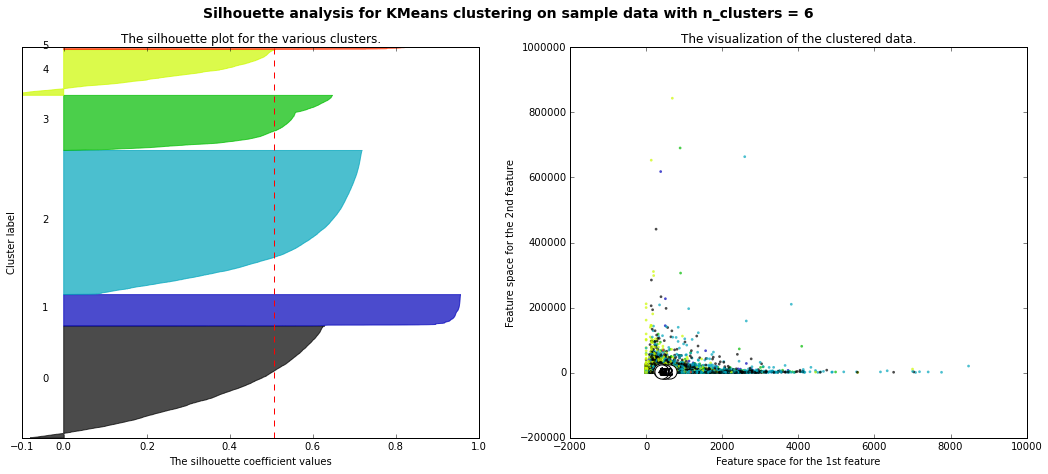

In [33]:
##############################################################################
# SILLOUHETTE ANALYSIS

range_n_clusters = [2, 3, 4, 5, 6]
metric='euclidean'
#cityblock
#cosine 
#manhattan 
#l1 
#l2

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels, metric=metric)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhoutte score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 2], X[:, 59], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 2], centers[:, 59],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(centers):
        ax2.scatter(c[2], c[59], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

3    21500
2     9004
0     5728
1     3185
4      227
Name: kmeans_5_clusters, dtype: int64


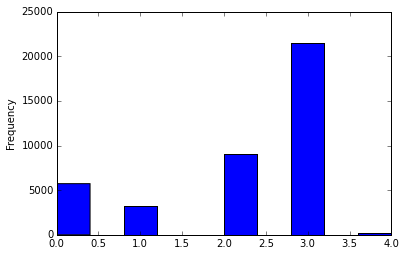

In [15]:
#View clusters by group
xyz = 5

clusterer = KMeans(n_clusters=xyz, random_state=10)
cluster_labels = clusterer.fit_predict(X)
us_file['kmeans_5_clusters']  = cluster_labels
print us_file.kmeans_5_clusters.value_counts()
us_file.kmeans_5_clusters.plot(kind='hist')


In [13]:
#Output results to csv for graphing and analysis in excel
by3c = us_file.groupby('kmeans_3_clusters')
by3c_mean = by3c.mean()
#by3c_mean.to_csv('by3c_mean.csv')

In [16]:
##Compare manual allocation of clusters to scikit-learn allocated
compare = pd.concat([original[['shares_2','shares_3', 'shares_5']], 
          us_file[['kmeans_2_clusters','kmeans_3_clusters','kmeans_5_clusters' ]]],
          axis=1)
print compare.count()

print compare[compare[compare.shares_2 == compare.kmeans_2_clusters] == True].count()
print compare[compare[compare.shares_3 == compare.kmeans_3_clusters] == True].count()
print compare[compare[compare.shares_5 == compare.kmeans_5_clusters] == True].count()


shares_2             39644
shares_3             39644
shares_5             39644
kmeans_2_clusters    39644
kmeans_3_clusters    39644
kmeans_5_clusters    39644
dtype: int64
shares_2             2463
shares_3              727
shares_5              701
kmeans_2_clusters    2463
kmeans_3_clusters    2463
kmeans_5_clusters    2462
dtype: int64
shares_2             6340
shares_3              727
shares_5              701
kmeans_2_clusters     727
kmeans_3_clusters     727
kmeans_5_clusters     726
dtype: int64
shares_2             6800
shares_3              846
shares_5              700
kmeans_2_clusters     700
kmeans_3_clusters     700
kmeans_5_clusters     700
dtype: int64


In [22]:
#Run through different number of clusters and types of measures 

# def var_cluster_size_distance(data):
#     n_range = [2,3,4,5,6]
#     metrics = ['euclidean', 'cityblock','cosine', 'manhattan', 'l1', 'l2']
#     print 'clusters, time, type_distance_metric, silhouette_score
    
#     for n in n_range: 
#         for m in metrics: 
#             clustering_start = time.time()
#             clust = KMeans(n_clusters=n, random_state=10)
#             clust_labels = clusterer.fit_predict(X)
#             s_score = silhouette_score(X, clust_labels, metric=m)
#             total_c_time = time.time() - clustering_start
#             print '%s clusters, % distance has silhouette score: %s' % (n, m, s_score )
        
# #var_cluster_size_distance(X)

In [ ]:
##### FUNCTIONS TO EVALUTE THE PERFORMANCE OF CLUSTERING AND DIFFERENCE DISTANCES 
#################################################################################
def k_means_scikit(matrix, n):
    k_means = skcluster.KMeans(n_clusters=n, init='k-means++',
                               n_init=1, verbose=0)
    k_means.fit(matrix)

    return k_means.labels_

def evaluate_performance(data, labels, metric='euclidean'):
    score = silhouette_score(data, labels, metric=metric)
    print('Score:', score)

    return score

def cluster_and_evaluate_data(matrix, metric='euclidean'):
    print('Clustering started')
    clustering_start = time.time()
    labels = k_means_scikit(matrix)
    clustering_total = time.time() - clustering_start
    print('Clustering time:', clustering_total)

    evaluation_start = time.time()
    score = evaluate_performance(matrix, labels, metric)
    evaluation_total = time.time() - evaluation_start
    print('Evaluation time:', evaluation_total)
    total = time.time() - clustering_start
    print('Total time:', total)

In [ ]:
cluster_and_evaluate_data(tip_matrix[:100])

In [1]:
import numpy as np
from scipy.cluster.vq import kmeans,vq
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

##### cluster data into K=1..10 clusters #####
#K, KM, centroids,D_k,cIdx,dist,avgWithinSS = kmeans.run_kmeans(X,10)

K = range(1,10)

# scipy.cluster.vq.kmeans
KM = [kmeans(X,k) for k in K] # apply kmeans 1 to 10
centroids = [cent for (cent,var) in KM]   # cluster centroids

D_k_euclidean = [cdist(X, cent, 'euclidean') for cent in centroids] 
D_k_seuclidean  = [cdist(X, cent, 'seuclidean') for cent in centroids] 
D_k_jaccard  = [cdist(X, cent, 'jaccard') for cent in centroids] 

# PC --- unsure of changing the distances here, sum of squares best fits and converges with Euclidean unsure how 
# to prove convergence of other distance and application of sum of squares 

#other distances can be found here: http://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html#scipy.spatial.distance.cdist
#minkowski
#wminkowski -- weighted minkowski
#seuclidean -- standardized euclidean measure between two n-vectors
#sqeuclidean -- square euclidean
# cosin distance 
#correlation -- between vectors 
# print 'EUCLIDEAN ', D_k_euclidean
# print 'SEUCLIDEAN ', D_k_seuclidean
# print 'JACCARD ', D_k_seuclidean


NameError: name 'X' is not defined

In [42]:
#assign values based on distance measure above
cIdx_euclidean = [np.argmin(D,axis=1) for D in D_k_euclidean]
dist_euclidean = [np.min(D,axis=1) for D in D_k_euclidean]
avgWithinSS_euclidean = [sum(d)/X.shape[0] for d in dist_euclidean] 

cIdx_seuclidean = [np.argmin(D,axis=1) for D in D_k_seuclidean]
dist_seuclidean = [np.min(D,axis=1) for D in D_k_seuclidean]
avgWithinSS_seuclidean = [sum(d)/X.shape[0] for d in dist_seuclidean] 

cIdx_jaccard = [np.argmin(D,axis=1) for D in D_k_jaccard]
dist_jaccard = [np.min(D,axis=1) for D in D_k_jaccard]
avgWithinSS_jaccard = [sum(d)/X.shape[0] for d in dist_jaccard] 

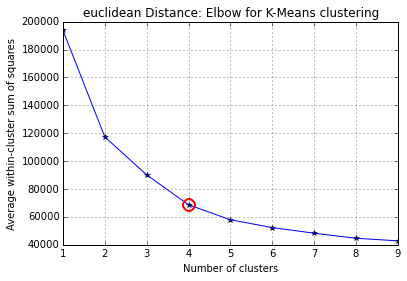

In [46]:
kIdx = 3
# plot elbow curve
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(K, avgWithinSS_euclidean, 'b*-')
ax.plot(K[kIdx], avgWithinSS_euclidean[kIdx], marker='o', markersize=12,          #plots a marker on the cluster
      markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster sum of squares')
tt = plt.title('euclidean Distance: Elbow for K-Means clustering')  

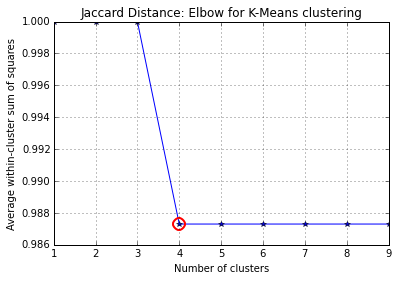

In [47]:
kIdx = 3
# plot elbow curve
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(K, avgWithinSS_jaccard, 'b*-')
ax.plot(K[kIdx], avgWithinSS_jaccard[kIdx], marker='o', markersize=12,          #plots a marker on the cluster
      markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster sum of squares')
tt = plt.title('Jaccard Distance: Elbow for K-Means clustering')  

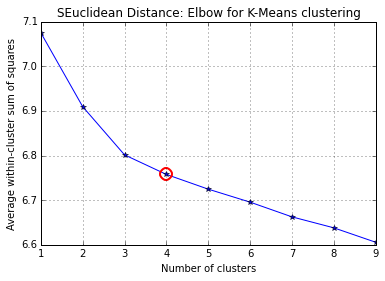

In [49]:
kIdx = 3
# plot elbow curve
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(K, avgWithinSS_seuclidean, 'b*-')
ax.plot(K[kIdx], avgWithinSS_seuclidean[kIdx], marker='o', markersize=12,          #plots a marker on the cluster
      markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster sum of squares')
tt = plt.title('SEuclidean Distance: Elbow for K-Means clustering')  

In [36]:
labels = y
# n_digits = len(np.unique(y))
# sample_size = 300

# print n_digits
#metrics = ['euclidean', 'cityblock','cosine', 'manhattan', 'l1', 'l2']
########################

print(79 * '_')
print('% 9s' % 'n_cluster  init'
      '          time  inertia      homo   compl  v-meas     ARI AMI  E-Sil    M-Sil    CB-Sil  Cosine-Sil')

def bench_k_means(n_digits, estimator, name, data):
    n_samples, n_features = data.shape
    
#     print("n_digits: %d, \t n_samples %d, \t n_features %d"
#       % (n_digits, n_samples, n_features))

    t0 = time.time()
    estimator.fit(data)
    print('%.3f,  % 9s,  %.2fs,  %i,   %.3f,   %.3f,   %.3f,   %.3f,   %.3f,    %.3f,   %.3f,   %.3f,   %.3f,'
          % (n_digits, name, (time.time() - t0), estimator.inertia_,
             metrics.homogeneity_score(labels, estimator.labels_),
             metrics.completeness_score(labels, estimator.labels_),
             metrics.v_measure_score(labels, estimator.labels_),
             metrics.adjusted_rand_score(labels, estimator.labels_),
             metrics.adjusted_mutual_info_score(labels,  estimator.labels_),
             metrics.silhouette_score(data, estimator.labels_,
                                      metric='euclidean',
                                      sample_size=sample_size),
             metrics.silhouette_score(data, estimator.labels_,
                                      metric='manhattan',
                                      sample_size=sample_size),
             metrics.silhouette_score(data, estimator.labels_,
                                      metric='cityblock',
                                      sample_size=sample_size),
             metrics.silhouette_score(data, estimator.labels_,
                                      metric='cosine',
                                      sample_size=sample_size)
            )
          )

n_digits = [2,3,4,5,6,7,8,9,10]
for nd in n_digits: 
    bench_k_means(nd, KMeans(init='k-means++', n_clusters=nd, n_init=10, random_state=10),
                  name="k-means++", data=data)
    bench_k_means(nd, KMeans(init='random', n_clusters=nd, n_init=10, random_state=10),
                  name="random", data=data)

    
# in this case the seeding of the centers is deterministic, hence we run the
# kmeans algorithm only once with n_init=1
# pca = PCA(n_components=n_digits).fit(data)
# bench_k_means(KMeans(init=pca.components_, n_clusters=n_digits, n_init=1),
#               name="PCA-based",
#               data=data)
# print(90 * '_')


_______________________________________________________________________________
n_cluster  init          time  inertia      homo   compl  v-meas     ARI AMI  E-Sil    M-Sil    CB-Sil  Cosine-Sil
2.000,  k-means++,  0.47s,  959273109961456,   0.245,   0.999,   0.393,   0.195,   0.245,    0.784,   0.796,   0.792,   0.702,
2.000,     random,  0.69s,  959273109961456,   0.245,   0.999,   0.393,   0.195,   0.245,    0.799,   0.790,   0.775,   0.704,
3.000,  k-means++,  1.93s,  596445631720663,   0.581,   0.797,   0.672,   0.578,   0.581,    0.464,   0.468,   0.447,   0.544,
3.000,     random,  1.73s,  596445301256359,   0.580,   0.796,   0.671,   0.577,   0.580,    0.520,   0.486,   0.468,   0.592,
4.000,  k-means++,  2.22s,  436140007394778,   0.996,   0.997,   0.997,   0.998,   0.996,    0.529,   0.521,   0.527,   0.207,
4.000,     random,  2.91s,  436141564617075,   0.998,   0.998,   0.998,   0.999,   0.998,    0.524,   0.529,   0.491,   0.201,
5.000,  k-means++,  2.15s,  315231953389080

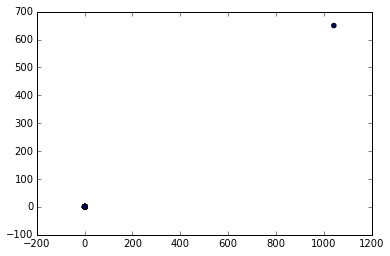

In [12]:
from sklearn.mixture import GMM

# g = GMM(n_components=2)
# print g.fit(X)
# print np.round(g.weights_, 2)
# print np.round(g.means_,2)
# print np.round(g.covars_,2)
# print g.converged_

clf = GMM(n_components=2)
clf.fit(X)
#print(clf.means_, clf.weights_, clf.covars_)

gmm = GMM(3, covariance_type='full', random_state=0)
gmm.fit(X)
cluster_label = gmm.predict(X)
plt.scatter(X[:, 2], X[:, 60], c=cluster_label);
#Add cluster label from GMM to original dataset